### Load line shapefile & merge line segments into correctly ordered LineString

In [1]:
import json
from App.classes.LineBuilder import create_ordered_line

data = json.load(open('shapefiles/gold_northbound/goldJSON.json'))

gold_line = create_ordered_line(data)

### Load Metro Station coordinates & filter for gold line

### Get station locations as % of line length

#### Relative Positions
This is the percentage of the distance along the line that station X occurs, from the start of the line (Atlantic Station is the first station at relative position = 0.002738)

In [2]:
from App.classes.Line import loadStations
stations = json.load(open('misc/GoldLineStationIds.json'))['items']
gold_line_stations = loadStations(stations, gold_line)
gold_line_stations.head()

,display_name,id,geometry,relative_position,line_id,station_id
0,Atlantic Station,80401,POINT (-118.15447 34.0333999),0.002717,804,01
1,East La Civic Center Station,80402,POINT (-118.16121 34.0333599),0.015767,804,02
2,Maravilla Station,80403,POINT (-118.16814 34.0333199),0.029182,804,03
3,Indiana Station,80404,POINT (-118.19218 34.0342999),0.077257,804,04
4,Soto Station,80405,POINT (-118.21006 34.0437499),0.117908,804,05


### Load tracking data & clean (remove dupes, set Datetime as index)

In [3]:
from App.classes.Tracker import rawLogToGDF
import pandas as pd

tracking_log = pd.read_csv("gold_24hrs.csv")
tracking_log = rawLogToGDF(tracking_log)
tracking_log.head()

,vehicle_id,direction,geometry
datetime,,,
2018-08-29 11:02:03,408,180,POINT (-118.132701 34.151845)
2018-08-29 11:02:14,404,180,POINT (-118.154466 34.033395)
2018-08-29 11:02:24,407,180,POINT (-118.157655 34.115352)
2018-08-29 11:02:35,401,0,POINT (-117.891003 34.136919)
2018-08-29 11:02:35,452,0,POINT (-118.073431 34.148369)


### select small window of tracked trains for analysis

In [5]:
from App.classes.Tracker import selectAnalysisWindow, findRelativePositions
start_date = '08/29/18 11:02:00'
end_date = '08/29/18 19:00:00'

analysis_window = selectAnalysisWindow(tracking_log, start_date, end_date)
analysis_window.head()

,datetime,vehicle_id,direction,geometry
0,2018-08-29 11:02:03,408,180,POINT (-118.132701 34.151845)
1,2018-08-29 11:02:14,404,180,POINT (-118.154466 34.033395)
2,2018-08-29 11:02:24,407,180,POINT (-118.157655 34.115352)
3,2018-08-29 11:02:35,401,0,POINT (-117.891003 34.136919)
4,2018-08-29 11:02:35,452,0,POINT (-118.073431 34.148369)


### Compare tracked trains to stations to find the next & previous stations for each train
Assuming direction 0 is northbound and 180 is southbound


In [6]:
from App.classes.Tracker import analyzeSelection
analysis_window = analyzeSelection(analysis_window, gold_line_stations, gold_line)
analysis_window.head()

,datetime,vehicle_id,direction,geometry,relative_position,previous_stop,next_stop
0,2018-08-29 11:02:03,408,180,POINT (-118.132701 34.151845),0.517066,Lake Station,Memorial Park Station
1,2018-08-29 11:02:14,404,180,POINT (-118.154466 34.033395),0.002709,Atlantic Station,Atlantic Station
2,2018-08-29 11:02:24,407,180,POINT (-118.157655 34.115352),0.412080,Fillmore Station,South Pasadena Station
3,2018-08-29 11:02:35,401,0,POINT (-117.891003 34.136919),0.997866,EOL,EOL
4,2018-08-29 11:02:35,452,0,POINT (-118.073431 34.148369),0.634175,Sierra Madre Villa Station,Arcadia Station


### Vehicles and Stations plotted:

The "Missing Station" stops above refer to the red dots below that fall beyond (east of) Sierra Madre Station - my gold line station data is missing the final 3 (?) stops.

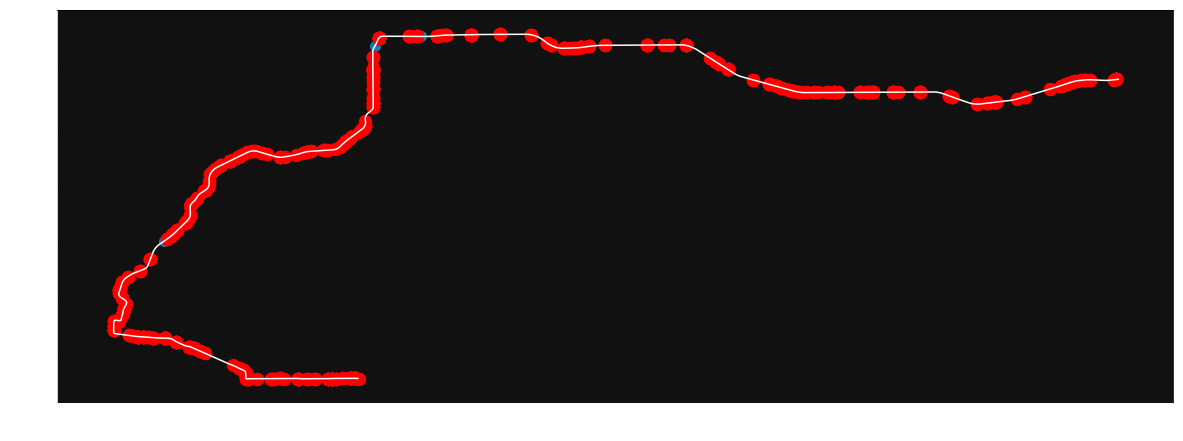

In [42]:
gold_line_plot = gpd.GeoSeries(gold_line)
gold_line_plot = gold_line_plot.plot(figsize=(20, 20), color="white")
gold_line_plot.set_facecolor("#111111")
gold_line_plot.spines['bottom'].set_color("white")
gold_line_plot.spines['left'].set_color("white")
gold_line_plot.xaxis.label.set_color('white')
gold_line_plot.tick_params(axis='x', colors='white')
gold_line_plot.yaxis.label.set_color('white')
gold_line_plot.tick_params(axis='y', colors='white')
gold_line_plot.set_xlabel('Longitude')
gold_line_plot.set_ylabel('Latitude')


gold_line_stations.plot(ax=gold_line_plot, markersize=100)
analysis_window.plot(ax=gold_line_plot, markersize=150, color="#ff0000")

In [43]:
analysis_window.loc[analysis_window['geometry'].y < 34]

,datetime,vehicle_id,direction,geometry,relative_position,next_stop,previous_stop


In [44]:
northbound = analysis_window.loc[analysis_window['direction'] == 0.].groupby('vehicle_id')
southbound = analysis_window.loc[analysis_window['direction'] == 180.].groupby('vehicle_id')
station_distances = gold_line_stations_sorted['relative_position']

In [45]:
analysis_window.geometry[0].y
analysis_window['datetime'].min()
vehicles = analysis_window['vehicle_id'].unique()

In [46]:
train_ids = list(analysis_window['vehicle_id'].unique())

In [48]:
import matplotlib.pyplot as plt
import random
import numpy as np

def random_color():
  return "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
number_of_colors = len(vehicles)

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
vals = np.linspace(0,1,15)
np.random.shuffle(vals)
colors = plt.cm.colors.ListedColormap(plt.cm.jet(vals))

colors = {train_ids[index]: colors(index) for index in range(len(train_ids))}

In [49]:
import matplotlib.pyplot as plt
import matplotlib
mmins = matplotlib.dates.MinuteLocator(byminute=None, interval=5, tz=None)
fmins = matplotlib.dates.DateFormatter('%H:%M')

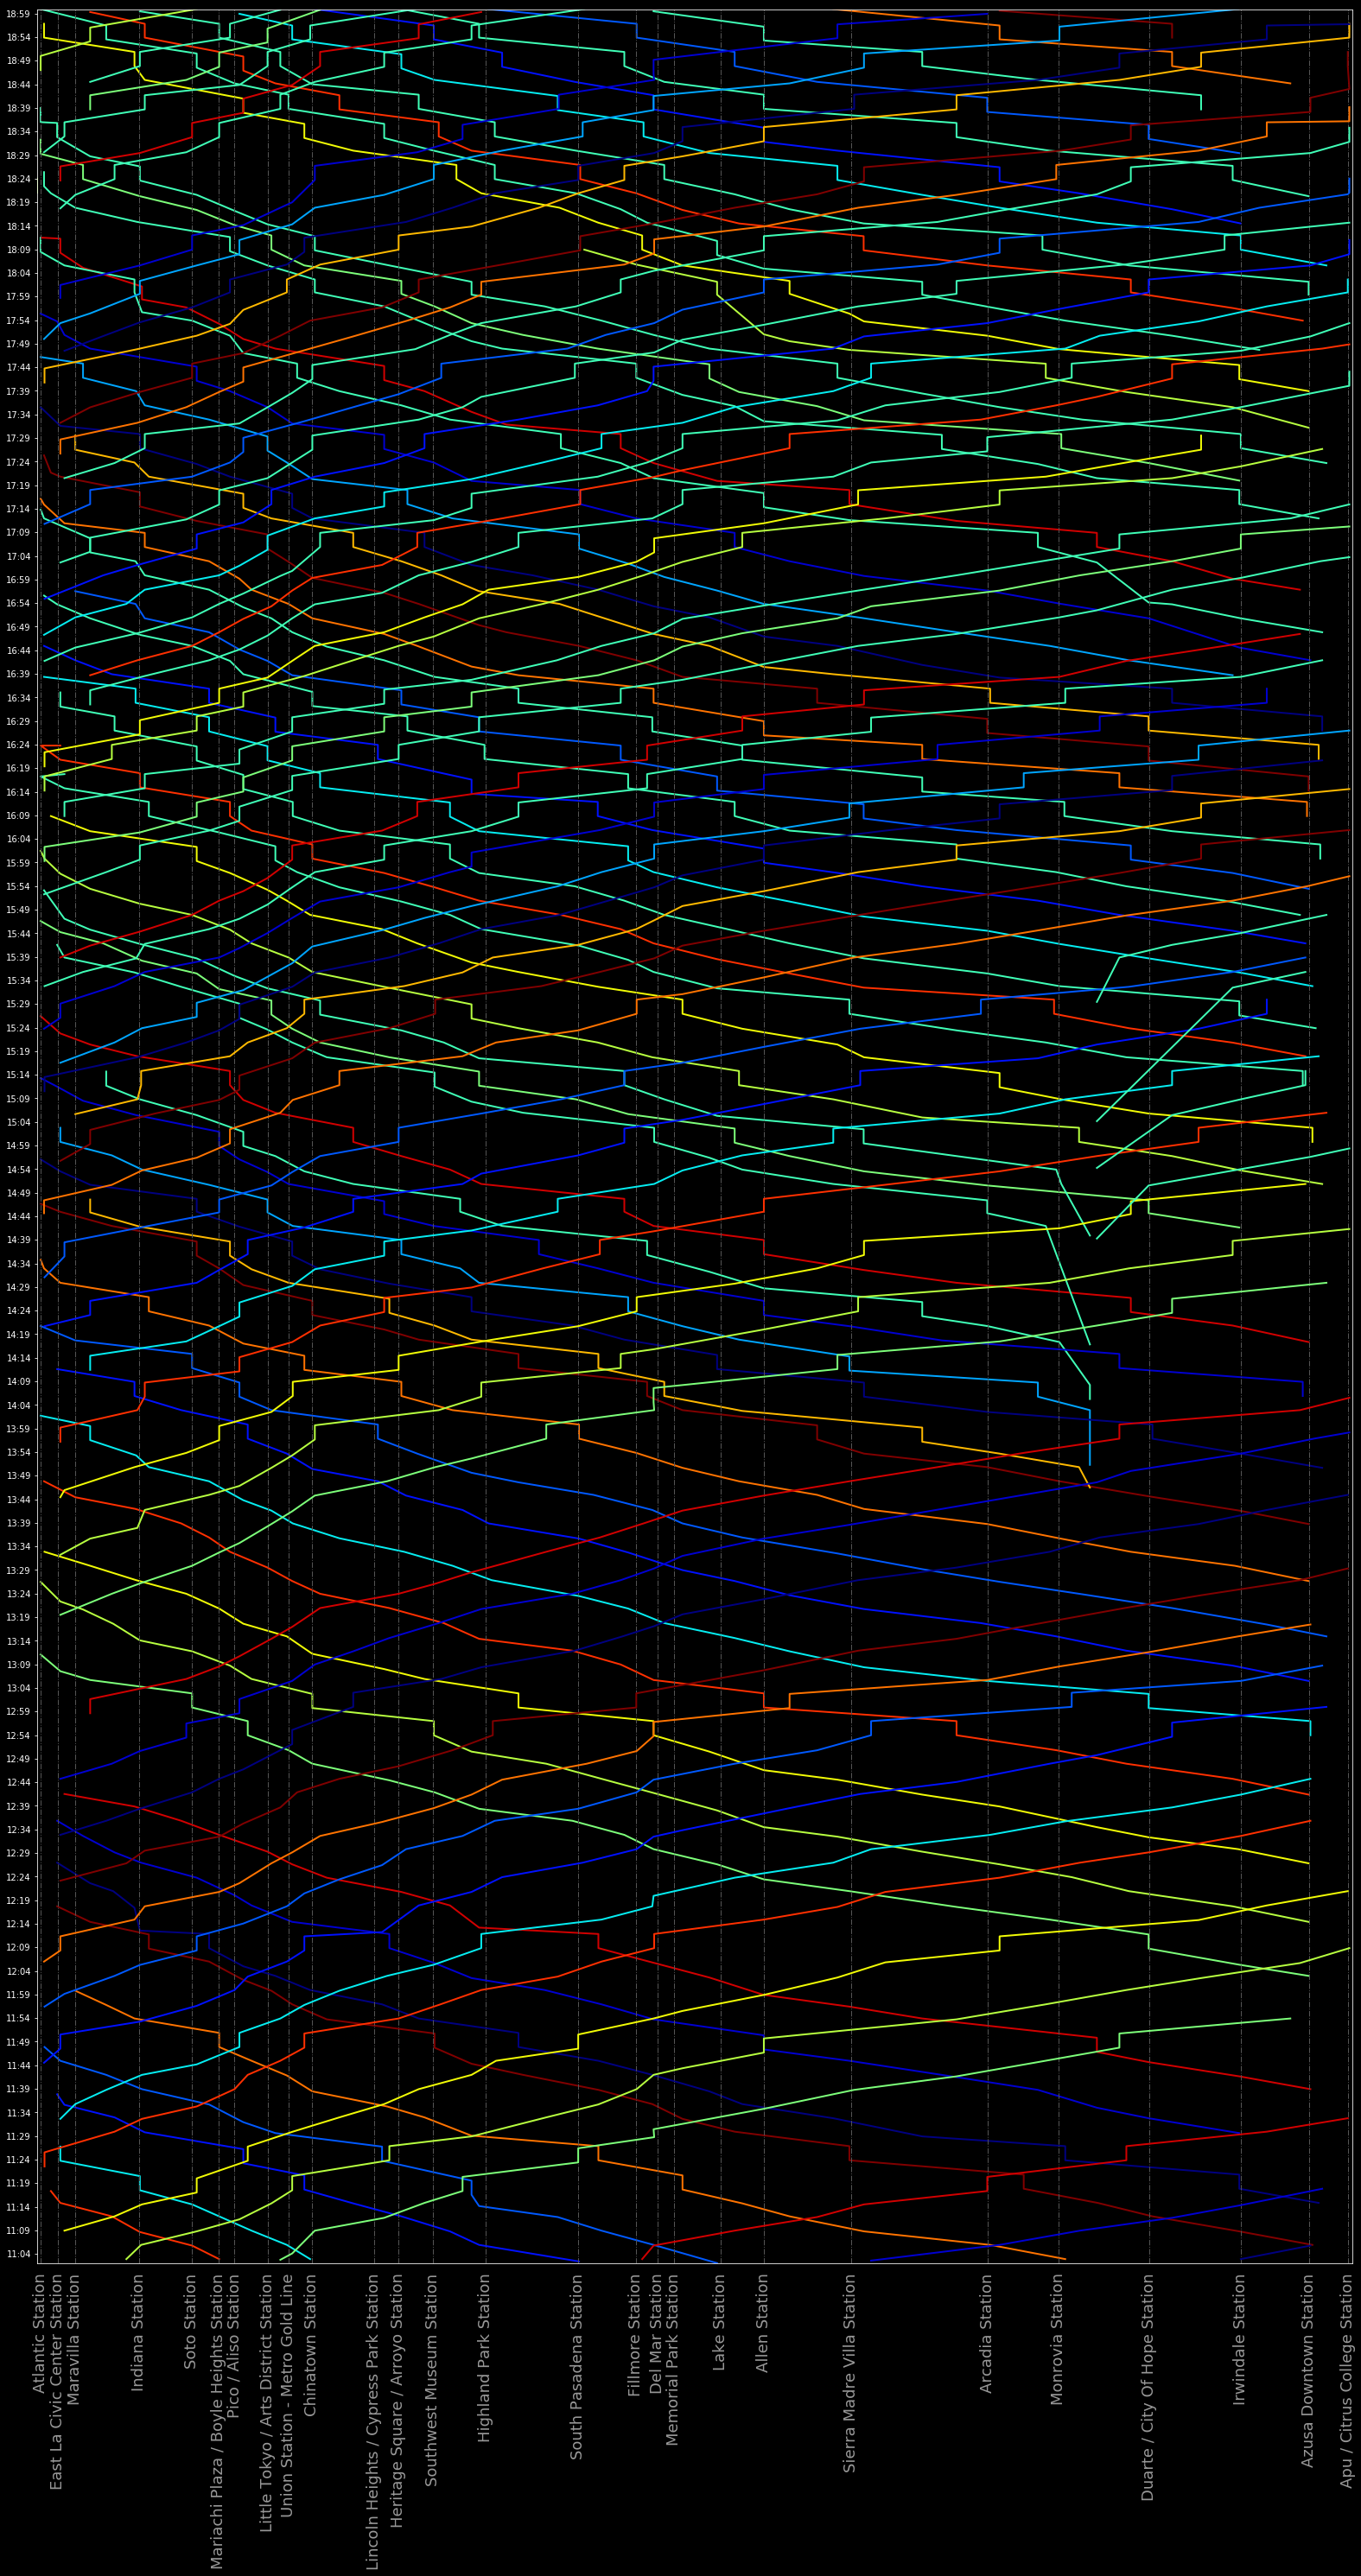

In [52]:
plt.style.use('dark_background')

def format_time_axis(axis):
  axis.set_ylim(analysis_window['datetime'].min(), analysis_window['datetime'].max())
  axis.yaxis.set_major_locator(mmins)
  axis.yaxis.set_major_formatter(fmins)
  axis.set_xlim(0, 1)

def format_location_axis(axis):
  axis.set_xticks([])

fig = plt.figure(figsize=[60,48])
ax1 = fig.add_subplot(121)
#ax2 = fig.add_subplot(122)
format_time_axis(ax1)
format_location_axis(ax1)
#format_time_axis(ax2)
#format_location_axis(ax2)

#plot southbound trains
for index, vehicle in southbound:
    times = vehicle['datetime']
    distances = vehicle['relative_position'].values
    nans = np.where(np.abs(np.diff(distances)) >= 0.2)[0]
    distances[nans] = np.nan
    ax1.plot(distances, times, lw=2, color=colors[index])
    
# plot stations
for index, row in gold_line_stations_sorted.iterrows():
  ax1.axvline(row['relative_position'], color='#555555', lw=1, linestyle='-.')
  ax1.text(row['relative_position'], analysis_window['datetime'].min(), row['display_name'] + '  ', fontSize='18', color='#999999', rotation='vertical', horizontalalignment='center', verticalalignment='top')
  #ax2.axvline(row['relative_position'], color='#555555', lw=1, linestyle='-.')
  #ax2.text(row['relative_position'], analysis_window['datetime'].min(), row['Station'] + '  ', fontSize='18', color='#999999', rotation='vertical', horizontalalignment='center', verticalalignment='top')
for index, vehicle in northbound:
    times = vehicle['datetime']
    distances = vehicle['relative_position'].values
    nans = np.where(np.abs(np.diff(distances)) >= 0.2)[0]
    distances[nans] = np.nan
    ax1.plot(distances, times, lw=2, color=colors[index])